In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sympy as sp
import at
import math
from tqdm import tqdm

# Selfmade files
from functions import *
from PID import *

# Import ring information
from rings.p3_elements_v24_c4l import *
# ring = load_mat('rings/hmba.mat')

In [2]:
# Lattice creation
lat = at.Lattice(ring, energy=6.e9)
lat.radiation_off()

# Obtaining Ids
cor_ids = at.get_refpts(lat, at.elements.Corrector)
bpm_ids = at.get_refpts(lat, at.elements.Monitor)
quad_ids = at.get_refpts(lat, at.elements.Quadrupole)

# BPMs positions
s_pos = lat.get_s_pos(bpm_ids)

Ring model:

$ y(t) = R_m \cdot \Delta q_i(t) + R_c \cdot \Delta \theta_i(t - \Delta t) $


In [3]:
dkick = 0.0001
offset = 0.0001
Rm, Rc = response_matrices(lat, dkick, offset, 1)

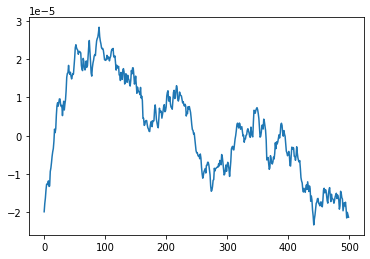

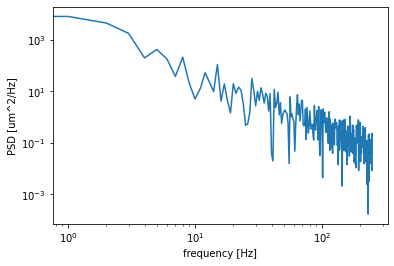

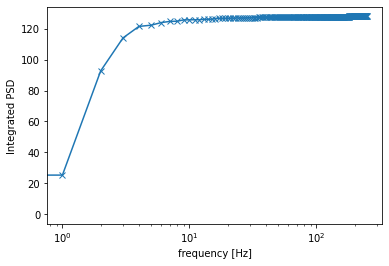

In [66]:
# Time configuration 
fs = 500
ts = 1/fs
t_max = 1
t = np.arange(int(fs*t_max))/fs
N = int(fs*t_max)
freqs = np.fft.fftfreq(N, 1/fs)

# Perturbations
# perturbation_samples = spectrum_noise(lambda f: 1 / f**0, N, fs) 

# fmin=1e-6
# fmax=1
# perturbation_samples = sinesweep(t, fmin, fmax, amplitude = 0.0001)

# perturbation_samples = real_perturbation(t) * 10e-6

# fsin = 1
# amplitude = 0.0001
# perturbation_samples = amplitude*np.sin(2*np.pi*t*fsin)

t0 = 0.1
perturbation_samples = np.piecewise(t, [t < t0, t >= t0], [0, 0.0001])

# def fftnoise(f):
#     f = np.array(f, dtype='complex')
#     Np = (len(f) - 1) // 2
#     phases = np.random.rand(Np) * 2 * np.pi
#     phases = np.cos(phases) + 1j * np.sin(phases)
#     f[1:Np+1] *= phases
#     f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
#     return np.fft.ifft(f).real

# def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
#     freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
#     f = np.zeros(samples)
#     idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
#     f[idx] = 1
#     return fftnoise(f)

# perturbation_samples = band_limited_noise(1, 1000, N, fs)

# plt.loglog(freqs[:N//2], np.abs(perturbation_samples)[:N//2])

# ******

# import colorednoise as cn

# beta = 2 # the exponent
# samples = N # number of samples to generate
# perturbation_samples = cn.powerlaw_psd_gaussian(beta, samples) * 10e-6

# plt.plot(perturbation_samples)
# plt.figure()
# plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((10e6 * perturbation_samples)/N))**2))[:N//2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [um^2/Hz]')

# plt.figure()

# aux = []
# for f in range(0, N//2):
#     aux.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((10e6 * perturbation_samples)/N))**2))[:f])))
# plt.plot(freqs[:N//2], aux, 'x-')
# plt.xlabel('frequency [Hz]')
# plt.ylabel('Integrated PSD')
# plt.xscale('log')

In [67]:
%matplotlib inline

# TRANSFER FUNCTIONS
# Low pass filter 
wc = 2 * np.pi * 715
num_lp = [wc]
den_lp = [1, wc]

# PID controller
Kp = 0
Ki = 1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

# Simulation configuration
quad_offset = np.zeros((t.size, len(quad_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))
corr_str_delay = np.zeros((t.size, len(cor_ids)))
orbit = np.zeros((t.size, len(bpm_ids)))
orbit_wc = np.zeros((t.size, len(bpm_ids)))
error = np.zeros((t.size, len(bpm_ids)))

reference_orbit = 0
rms = []
x_lp = np.zeros(len(cor_ids)*(len(den_lp)-1))
x_pid = np.zeros(len(bpm_ids)*(len(den_pid)-1))

# Delay configuration
loop_delay = 0
# loop_delay = 131e-3
delay_offset = math.ceil(loop_delay*fs) 
print(delay_offset)

# Inverse of reponse matrix 
n_sv = 80
Rcinv = svd_solve(Rc, n_sv)

# TEMPORAL TO DELETE
mov = []
rec = []

# Simulation
for n in tqdm(range(1, t.size)):
    # Error calculation
    error[n, :] = reference_orbit - orbit[n-1, :]

    # PID controller
    PID_out, x_pid = apply_f(num_pid, den_pid, error[n, :], x_pid, ts)

    # Correctors str
    corr_str[n, :] = np.dot(Rcinv.T, PID_out)
    # corr_str[n, :] = np.dot(Rcinv.T, 1.1 * error[n, :])

    # Apply delay
    if n >= delay_offset:
        corr_str_delay[n, :] = corr_str[n - delay_offset, :]

    # Correctors response
    filter_out, x_lp = apply_f(num_lp, den_lp, corr_str_delay[n, :], x_lp, ts)

    # Adding perturbation 
    quad_offset[n, :] = quad_offset[n, :] + perturbation_samples[n]
   
    # Orbit calculation
    
    # change_magnets_alignment(lat, perturbation_samples[n])
    # change_correctors_kick_angle(lat, filter_out)
    # out1, out2 = at.find_orbit4(lat, refpts=bpm_ids) 
    # orbit[n, :] = out2[:, 0]

    orbit_wc[n, :] = np.dot(Rm.T, quad_offset[n, :]) 
    # orbit[n, :] = np.dot(Rm.T, quad_offset[n, :]) + np.dot(Rc.T, corr_str_delay[n, :])
    orbit[n, :] = np.dot(Rm.T, quad_offset[n, :]) + np.dot(Rc.T, filter_out)
    
    mov.append(np.dot(Rm.T, quad_offset[n, :])[0])
    rec.append(np.dot(Rc.T, filter_out)[0])
    rms.append(np.sqrt(np.mean(np.square(orbit[n, :]))))

0


  9%|▉         | 45/499 [00:06<01:16,  5.92it/s]/tmp/ipykernel_91712/1943872038.py:77: RuntimeWarning: overflow encountered in square
  rms.append(np.sqrt(np.mean(np.square(orbit[n, :]))))
100%|██████████| 499/499 [01:23<00:00,  6.01it/s]


/tmp/ipykernel_91712/3265888332.py:26: RuntimeWarning: overflow encountered in multiply
  plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((10e6 * orbit[:, 0])/N))**2))[:N//2], 'b-')
/tmp/ipykernel_91712/3265888332.py:37: RuntimeWarning: overflow encountered in multiply
  aux2.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((10e6 * orbit[:, 0])/N))**2))[:f])))


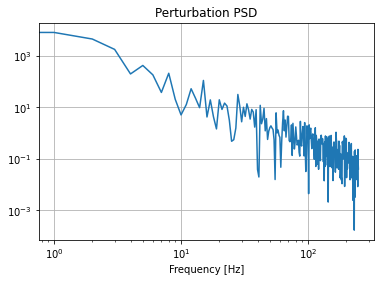

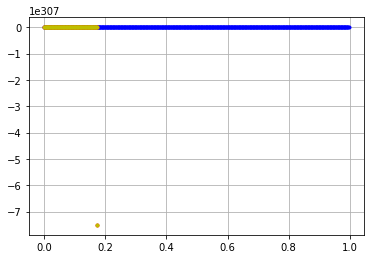

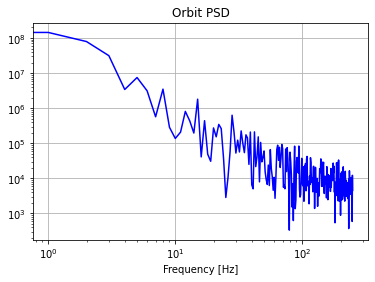

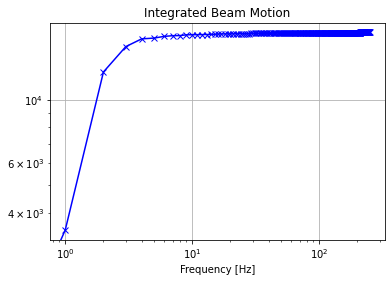

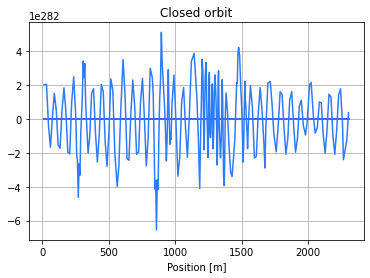

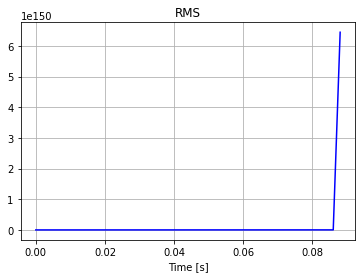

In [68]:
# Plotting
# plt.plot(t, perturbation_samples[:])
# plt.xlabel('Time [s]')
# plt.title('Perturbation')

# plt.figure()

plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((10e6 * perturbation_samples)/N))**2))[:N//2])
plt.xlabel('Frequency [Hz]')
plt.title('Perturbation PSD')
plt.grid()

plt.figure()

plt.plot(t[:len(t)-1], mov[:], 'b.')
plt.plot(t[:len(t)-1], rec[:], 'r.')
res = np.zeros(len(mov))
for i in range(0, len(mov)):
    res[i] = mov[i] + rec[i]
plt.plot(t[:len(t)-1], res[:], 'y.')
plt.grid()

plt.figure()

plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((10e6 * orbit_wc[:, 0])/N))**2))[:N//2], 'b-')
plt.loglog(freqs[:N//2], (2*(np.abs(np.fft.fft((10e6 * orbit[:, 0])/N))**2))[:N//2], 'b-')
plt.xlabel('Frequency [Hz]')
plt.title('Orbit PSD')
plt.grid()

plt.figure()

aux = []
aux2 = []
for f in range(0, N//2):
    aux.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((10e6 * orbit_wc[:, 0])/N))**2))[:f])))
    aux2.append(np.sqrt(np.sum((2*(np.abs(np.fft.fft((10e6 * orbit[:, 0])/N))**2))[:f])))
plt.loglog(freqs[:N//2], aux, 'bx-')
plt.loglog(freqs[:N//2], aux2, 'ro-')
plt.xlabel('Frequency [Hz]')
plt.title('Integrated Beam Motion')
plt.xscale('log')
plt.grid()

plt.figure()

color = iter(plt.cm.rainbow(np.linspace(0, 1, int(t.size/10))))
for n in range(1, t.size):
    if n%10 == 1:
        c = next(color)
        plt.plot(s_pos, orbit[n, :], c=c, label=n)
# plt.legend(loc='best')
plt.xlabel('Position [m]')
plt.title('Closed orbit')
plt.grid()

plt.figure()

plt.plot(t[:len(t)-1], rms, 'b-')
plt.xlabel('Time [s]')
plt.title('RMS')
plt.grid()

# ****************************************************************

In [ ]:
# ts = 1/150
# wc = 2 * np.pi * 715
# num = [wc]
# den = [1, wc]
Kp = 1
Ki = 1
Kd = 2
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

wc = 2 * np.pi * 30
num_lp = [wc]
den_lp = [1, wc]
    
sys = signal.TransferFunction(num_lp, den_lp)

w , mag, phase = signal.bode(sys)
plt.plot(w, mag)
plt.figure()
plt.plot(w, phase)

In [ ]:
%matplotlib inline

# Time configuration 
fs = 150
ts = 1/fs
t_max = 3
t = np.arange(int(fs*t_max))/fs
N = int(fs*t_max)

# Perturbations
# perturbation_samples = spectrum_noise(lambda f: 1 / f**0, N, fs) 

# fmin=1e-3
# fmax=75
# perturbation_samples = sinesweep(t, fmin, fmax)

# fsin = 10
# amplitude = 1
# perturbation_samples = amplitude*np.sin(2*np.pi*t*fsin)

# t0 = 0.1
# perturbation_samples = np.piecewise(t, [t < t0, t >= t0], [0, 0.0001])

# TRANSFER FUNCTIONS
# Low pass filter 
wc = 2 * np.pi * 200
num_lp = [wc]
den_lp = [1, wc]

# PID controller
Kp = 0
Ki = 1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

# Simulation configuration
quad_offset = np.zeros((t.size, len(quad_ids)))
quad_offset2 = np.zeros((t.size, len(quad_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))
corr_str_delay = np.zeros((t.size, len(cor_ids)))
orbit = np.zeros((t.size, len(bpm_ids)))
error = np.zeros((t.size, len(bpm_ids)))

reference_orbit = 0
rms = []
x_lp = np.zeros(len(quad_ids)*(len(den_lp)-1))
x_pid = np.zeros(len(bpm_ids)*(len(den_pid)-1))

# Delay configuration
loop_delay = 131e-3
delay_offset = math.ceil(loop_delay*fs) 

# Inverse of reponse matrix 
n_sv = 80
Rcinv = svd_solve(Rc, n_sv)

# Simulation
for n in tqdm(range(1, t.size)):
    quad_offset[n, :] = quad_offset[n, :] + perturbation_samples[n]
    quad_offset2[n, :], x_lp = apply_f(num_lp, den_lp, quad_offset[n, :], x_lp, ts)

freqs = np.fft.fftfreq(N, 1/fs)
plt.plot(freqs[:N//2], np.abs(np.fft.fft(perturbation_samples))[:N//2]*(2/len(perturbation_samples)))
plt.xlabel('Frequency [Hz]')
plt.title('Perturbation PSD')

plt.figure()

plt.plot(freqs[:N//2], np.abs(np.fft.fft(quad_offset2[:, 0]))[:N//2]*(2/len(quad_offset2[:, 0])))
plt.xlabel('Frequency [Hz]')
plt.title('Error PSD in element 0')

In [ ]:
def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    plt.loglog(f, np.abs(np.fft.rfft(s)))

def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N))
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S
        return np.fft.irfft(X_shaped)

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

plt.figure(figsize=(8, 8))
for G in [pink_noise]:
    plot_spectrum(G(2**14))
plt.ylim([1e-3, None])